In [1]:
!pip install ipywidgets transformers[torch] datasets ipywidgets torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of ipython to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement jedi>=0.16 (from ipython) (from versions: none)
ERROR: No matching distribution found for jedi>=0.16


In [2]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Load Dataset**

In [3]:
from datasets import load_dataset
dataset = load_dataset("mdwiratathya/SLAKE-vqa-english")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/12.2M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/8.34M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/9.59M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4919 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1053 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1061 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 4919
    })
    validation: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1053
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1061
    })
})

**Data Sample Visualization**

Question: Which part of the body does this image belong to?
Answer: Abdomen


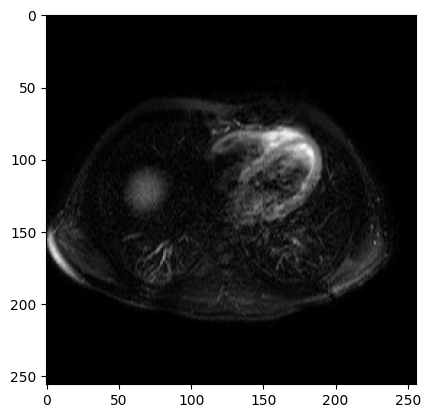

In [5]:
data_sample = dataset['train'][1]
processed_pil_image = Image.fromarray(np.array(data_sample['image'])).convert('RGB')
plt.imshow(data_sample['image'].convert('RGB'))
print("Question: {}".format(data_sample['question']))
print("Answer: {}".format(data_sample['answer']))

# Task


Question Types

In [6]:
def categorize_question(question):
    question_lower = question.lower()
    open_ended_starters = ['what', 'how', 'why', 'describe', 'explain', 'tell me about']
    closed_ended_starters = ['is', 'are', 'do', 'does', 'can', 'could', 'will', 'would', 'should', 'did', 'has', 'have', 'had']

    for starter in closed_ended_starters:
        if question_lower.startswith(starter + ' '):
            return 'closed-ended'
    for starter in open_ended_starters:
        if question_lower.startswith(starter + ' '):
            return 'open-ended'

    # Fallback: if no clear starter, consider it open-ended as it's harder to define all open-ended patterns.
    # Or we could analyze answer type, but for now, based on phrasing.
    return 'open-ended'

print("Question categorization function defined.")

Question categorization function defined.


In [7]:
question_type_distributions = {}

for split_name, split_dataset in dataset.items():
    question_types = [categorize_question(q) for q in split_dataset['question']]

    open_ended_count = question_types.count('open-ended')
    closed_ended_count = question_types.count('closed-ended')
    total_questions = len(question_types)

    distribution = {
        'open-ended': open_ended_count,
        'closed-ended': closed_ended_count,
        'total': total_questions,
        'open_ended_proportion': open_ended_count / total_questions if total_questions > 0 else 0,
        'closed_ended_proportion': closed_ended_count / total_questions if total_questions > 0 else 0
    }
    question_type_distributions[split_name] = distribution

print("Question type distributions calculated for all splits:")
for split, dist in question_type_distributions.items():
    print(f"\nSplit: {split}")
    for key, value in dist.items():
        print(f"  {key}: {value}")


Question type distributions calculated for all splits:

Split: train
  open-ended: 3258
  closed-ended: 1661
  total: 4919
  open_ended_proportion: 0.6623297418174425
  closed_ended_proportion: 0.3376702581825574

Split: validation
  open-ended: 700
  closed-ended: 353
  total: 1053
  open_ended_proportion: 0.6647673314339981
  closed_ended_proportion: 0.3352326685660019

Split: test
  open-ended: 706
  closed-ended: 355
  total: 1061
  open_ended_proportion: 0.6654099905749293
  closed_ended_proportion: 0.33459000942507067


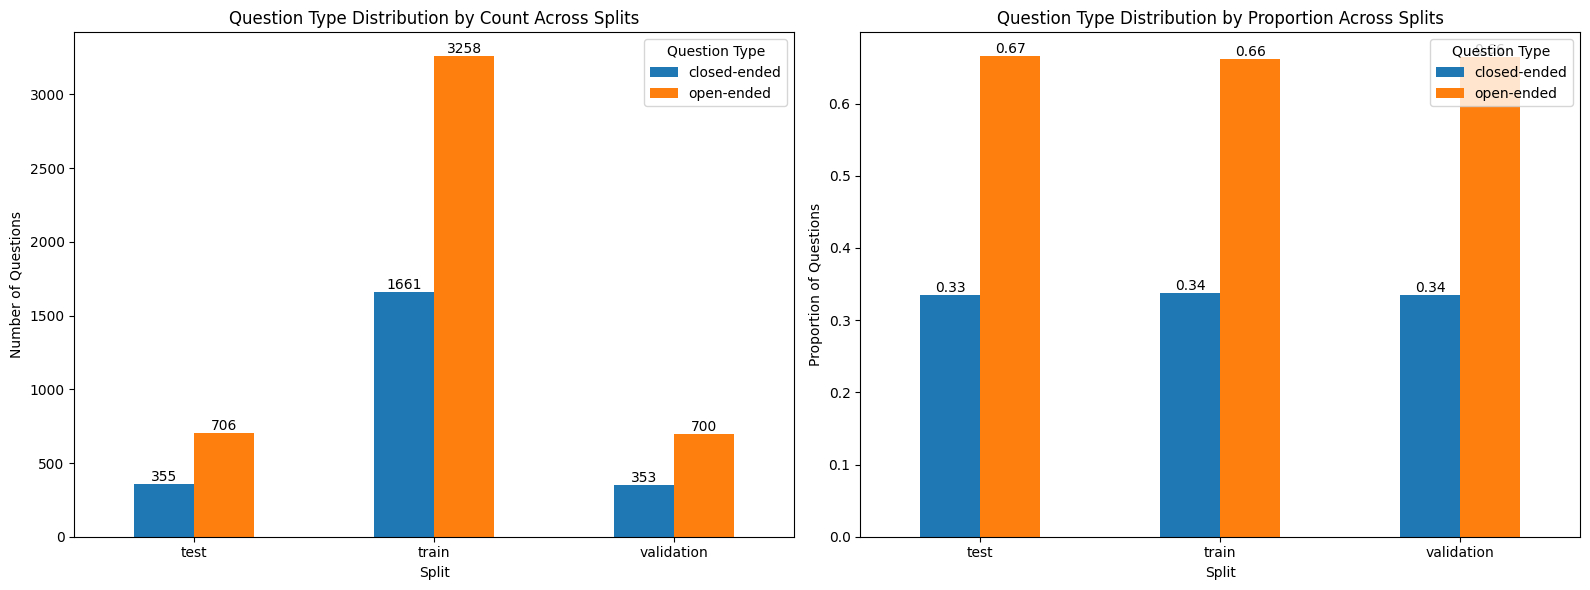

Bar charts showing the distribution of open-ended and closed-ended questions across all dataset splits have been generated.


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
plot_data = []
for split, dist in question_type_distributions.items():
    plot_data.append({
        'Split': split,
        'Question Type': 'open-ended',
        'Count': dist['open-ended'],
        'Proportion': dist['open_ended_proportion']
    })
    plot_data.append({
        'Split': split,
        'Question Type': 'closed-ended',
        'Count': dist['closed-ended'],
        'Proportion': dist['closed_ended_proportion']
    })

df_question_types = pd.DataFrame(plot_data)

# Create a bar chart for question type distribution by count
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot counts
df_question_types.pivot(index='Split', columns='Question Type', values='Count').plot(kind='bar', ax=axes[0], rot=0)
axes[0].set_title('Question Type Distribution by Count Across Splits')
axes[0].set_ylabel('Number of Questions')
axes[0].tick_params(axis='x', labelrotation=0)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='edge')

# Plot proportions
df_question_types.pivot(index='Split', columns='Question Type', values='Proportion').plot(kind='bar', ax=axes[1], rot=0)
axes[1].set_title('Question Type Distribution by Proportion Across Splits')
axes[1].set_ylabel('Proportion of Questions')
axes[1].tick_params(axis='x', labelrotation=0)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', label_type='edge')

plt.tight_layout()
plt.show()

print("Bar charts showing the distribution of open-ended and closed-ended questions across all dataset splits have been generated.")


## Identify Most Common Words



In [9]:
all_questions = []

for split_name, split_dataset in dataset.items():
    all_questions.extend(split_dataset['question'])

print(f"Total questions collected from all splits: {len(all_questions)}")

Total questions collected from all splits: 7033


In [10]:
from collections import Counter
import string

word_counts = Counter()

for question in all_questions:
    question_lower = question.lower()
    question_cleaned = question_lower.translate(str.maketrans('', '', string.punctuation))
    words = question_cleaned.split()
    word_counts.update(words)

print("20 most common words in questions:")
for word, count in word_counts.most_common(20):
    print(f"'{word}': {count}")

20 most common words in questions:
'the': 7544
'is': 3441
'this': 3366
'in': 3314
'image': 3139
'what': 2360
'picture': 2307
'of': 1942
'does': 1840
'organ': 1278
'which': 1242
'to': 1098
'contain': 959
'lung': 791
'part': 657
'body': 618
'belong': 579
'are': 570
'on': 566
'where': 557


## Analyze Text Lengths




In [11]:
question_lengths = []
answer_lengths = []

print("Empty lists initialized for question and answer lengths.")

Empty lists initialized for question and answer lengths.


In [12]:
import string

for split_name, split_dataset in dataset.items():
    for i in range(len(split_dataset['question'])):
        question = split_dataset['question'][i]
        answer = split_dataset['answer'][i]

        # Preprocess question
        question_lower = question.lower()
        question_cleaned = question_lower.translate(str.maketrans('', '', string.punctuation))
        question_words = question_cleaned.split()
        question_lengths.append(len(question_words))

        # Preprocess answer
        answer_lower = answer.lower()
        answer_cleaned = answer_lower.translate(str.maketrans('', '', string.punctuation))
        answer_words = answer_cleaned.split()
        answer_lengths.append(len(answer_words))

print(f"Total question lengths collected: {len(question_lengths)}")
print(f"Total answer lengths collected: {len(answer_lengths)}")

Total question lengths collected: 7033
Total answer lengths collected: 7033


In [13]:
import numpy as np

# Calculate descriptive statistics for question lengths
question_lengths_array = np.array(question_lengths)
question_min_length = np.min(question_lengths_array)
question_max_length = np.max(question_lengths_array)
question_avg_length = np.mean(question_lengths_array)
question_std_length = np.std(question_lengths_array)

# Calculate descriptive statistics for answer lengths
answer_lengths_array = np.array(answer_lengths)
answer_min_length = np.min(answer_lengths_array)
answer_max_length = np.max(answer_lengths_array)
answer_avg_length = np.mean(answer_lengths_array)
answer_std_length = np.std(answer_lengths_array)

print("\nDescriptive Statistics for Question Lengths (Word Count):")
print(f"  Minimum: {question_min_length}")
print(f"  Maximum: {question_max_length}")
print(f"  Average: {question_avg_length:.2f}")
print(f"  Standard Deviation: {question_std_length:.2f}")

print("\nDescriptive Statistics for Answer Lengths (Word Count):")
print(f"  Minimum: {answer_min_length}")
print(f"  Maximum: {answer_max_length}")
print(f"  Average: {answer_avg_length:.2f}")
print(f"  Standard Deviation: {answer_std_length:.2f}")


Descriptive Statistics for Question Lengths (Word Count):
  Minimum: 4
  Maximum: 21
  Average: 8.02
  Standard Deviation: 2.96

Descriptive Statistics for Answer Lengths (Word Count):
  Minimum: 1
  Maximum: 12
  Average: 1.40
  Standard Deviation: 1.18


**Reasoning**:
Now that the descriptive statistics are calculated, I will visualize the distribution of question and answer lengths using histograms, as specified in the main task instructions to analyze the textual characteristics of the SLAKE dataset.



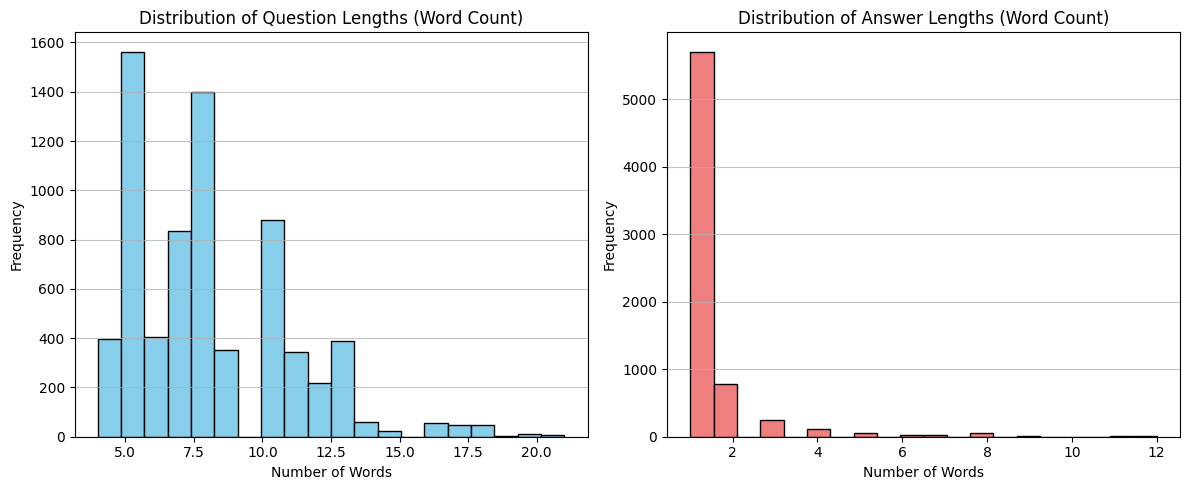

Histograms showing the distribution of question and answer lengths have been generated.


In [14]:
import matplotlib.pyplot as plt

# Plotting histograms for question lengths
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(question_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Question Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Plotting histograms for answer lengths
plt.subplot(1, 2, 2)
plt.hist(answer_lengths, bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution of Answer Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

print("Histograms showing the distribution of question and answer lengths have been generated.")

## Visualize Most Common Words




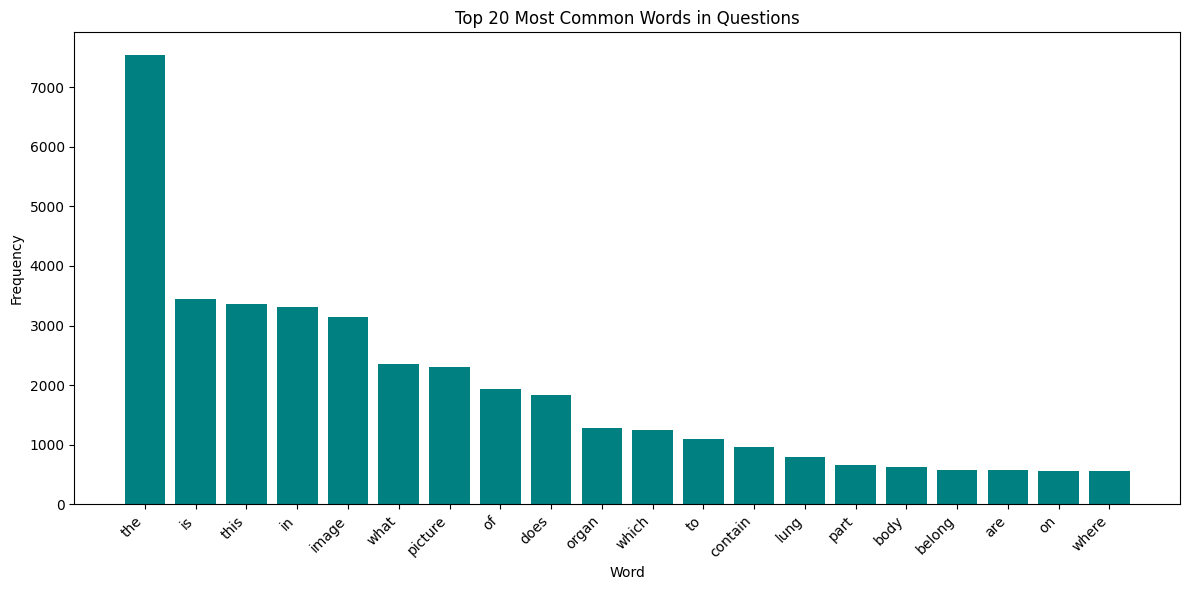

Bar chart showing the top 20 most common words in questions has been generated.


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the 20 most common words and their counts
top_20_words = word_counts.most_common(20)

# Convert to a DataFrame for easier plotting
df_top_words = pd.DataFrame(top_20_words, columns=['Word', 'Count'])

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_top_words['Word'], df_top_words['Count'], color='teal')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Questions')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

print("Bar chart showing the top 20 most common words in questions has been generated.")